In [2]:
#################
#### IMPORTS ####
#################

# Arrays
import numpy as np
import cytoolz

# Deep Learning stuff
import torch
import torchvision
import torchvision.transforms as transforms

# Images display and plots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.colors import ListedColormap
import matplotlib.pylab as pl

# Fancy progress bars
import tqdm.notebook as tq

# Tensor Network Stuff
%config InlineBackend.figure_formats = ['svg']
import quimb.tensor as qtn # Tensor Network library
import quimb

import collections
import opt_einsum as oe
import itertools
import copy


In [3]:
import sys, os
sys.path.insert(0, '../')
# My functions
from TNutils import *


In [4]:
def meanpool2d_gs(npmnist, shape):
    '''
    Apply a meanpool convolution of an array of images (flattened)
    meanpool has kernel size 2x2
    '''
    ds_imgs = []
    for img in npmnist:
        ds_img = []
        for col in range(0,shape[0],2):
            for row in range(0,shape[1],2):
                pixel = np.mean([img.reshape(shape)[col,row], img.reshape(shape)[col,row+1],
                                 img.reshape(shape)[col+1,row], img.reshape(shape)[col+1,row+1]])
                
                ds_img.append(pixel)

        ds_imgs.append(np.array(ds_img).reshape((shape[0]//2)*(shape[1]//2)) )
        
    ds_imgs = np.array(ds_imgs)
    
    return ds_imgs

In [5]:
def get_data_gs(train_size = 1000, test_size = 100, grayscale_threshold = .5, reduced = False):
    '''
    Prepare the MNIST dataset for the training algorithm:
     * Choose randomly a subset from the whole dataset
     * Flatten each image to mirror the mps structure
     * Normalize images from [0,255] to [0,1]
     * Apply a threshold for each pixels so that each value 
       below that threshold are set to 0, the others get set to 1.
       For this algorithm we will only deal to binary states {0,1}
       instead of a range from 0 to 1    
    '''
    # Download all data
    mnist = torchvision.datasets.MNIST('classifier_data', train=True, download=True,
                                                  transform = transforms.Compose([transforms.ToTensor()]) )
    
    # Convert torch.tenor to numpy
    npmnist = mnist.data.numpy()
    
    # Check of the type of the sizes
    #if ((type(train_size) != int) or (type(test_size) != int)):
    #    raise TypeError('train_size and test_size must be INT')
    
    # Check if the training_size and test_size requested are bigger than
    # the MNIST whole size
    if ( (train_size + test_size) > npmnist.shape[0] ):
        raise ValueError('Subset too big') 
    
    # Check of the positivity of sizes
    if ( (train_size <= 0) or (test_size <= 0) ):
        raise ValueError('Size of training set and test set cannot be negative')
    
    # Choose just a subset of the data
    # Creating a mask by randomly sampling the indexes of the full dataset
    subset_indexes = np.random.choice(np.arange(npmnist.shape[0]), size=(train_size + test_size), 
                                      replace=False, p=None)
    
    # Apply the mask
    npmnist = npmnist[subset_indexes]

    # Flatten every image
    npmnist = np.reshape(npmnist, (npmnist.shape[0], npmnist.shape[1]*npmnist.shape[2]))
    
    # Normalize the data from 0 - 255 to 0 - 1
    if reduced:
        npmnist = np.array(npmnist/npmnist.max() )
        npmnist = meanpool2d_gs(npmnist, (28,28))
    
    npmnist = np.round(3*np.array(npmnist/npmnist.max() ),0)
    npmnist_bits = []
    for image in npmnist:
        image_bits = []
        for pixel in image:
            if pixel == 0:
                image_bits.append(0)
                image_bits.append(0)
            elif pixel == 1:
                image_bits.append(0)
                image_bits.append(1)
            elif pixel == 2:
                image_bits.append(1)
                image_bits.append(0)
            elif pixel == 3:
                image_bits.append(1)
                image_bits.append(1)
        npmnist_bits.append(np.array(image_bits))
    # Return training set and test set
    return npmnist_bits[:train_size], npmnist_bits[train_size:]

In [130]:
def binary_to_img(img_flat_bits, shape):
    img_flat = []
    for k in range(0,2*shape[0]*shape[1],2):
        if img_flat_bits[k] == 0 and img_flat_bits[k+1] == 0:
            img_flat.append(0)
        elif img_flat_bits[k] == 0 and img_flat_bits[k+1] == 1:
            img_flat.append(1)
        elif img_flat_bits[k] == 1 and img_flat_bits[k+1] == 0:
            img_flat.append(2)
        elif img_flat_bits[k] == 1 and img_flat_bits[k+1] == 1:
            img_flat.append(3)
        else:
            img_flat.append(-1)
    
    img_flat = np.array(img_flat)
    
    return img_flat

In [111]:
def plot_img_gs(img_flat_bits, shape, flip_color = True, savefig = ''):
    '''
    Display the image from the flattened form
    '''
    # If the image is corrupted for partial reconstruction (pixels are set to -1)
    img_flat = binary_to_img(img_flat_bits, shape)
    if -1 in img_flat:
        img_flat = np.copy(img_flat)
        img_flat[img_flat == -1] = 0
    plt.figure(figsize = (2,2))
    # Background white, strokes black
    if flip_color:
        plt.imshow(1-np.reshape(img_flat,shape), cmap='gray')
    # Background black, strokes white
    else:
        plt.imshow(np.reshape(img_flat,shape), cmap='gray')
        
    plt.axis('off')
    
    if savefig != '':
        # save the picture as svg in the location determined by savefig
        plt.savefig(savefig, format='svg')
        plt.show()

In [7]:
data, _ = get_data_gs(reduced = True)

In [10]:
data = np.array(data)[:10]

In [11]:
data.shape

(10, 392)

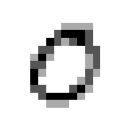

In [112]:
plot_img_gs(data[0], (14,14))

In [15]:
mps = initialize_mps(28*14,2)

In [16]:
#########################
# CHACHE INITIALIZATION #
#########################

# Creating list of tensor of the images of the training set
_imgs = np.array([tens_picture(img) for img in data])

_img_cache = []
for _img in _imgs:
    _left_cache = np.array([qtn.Tensor() for _ in range(len(_img))])
    _right_cache = np.array([qtn.Tensor() for _ in range(len(_img))])
    _img_cache.append((_left_cache,_right_cache))
_img_cache = np.array(_img_cache)

last_dirs = np.zeros(len(_img_cache),dtype =np.int32)
last_sites = np.zeros(len(_img_cache),dtype =np.int32)
last_epochs = -np.ones(len(_img_cache),dtype =np.int32)

In [17]:
nlls = cached_stochastic_learning_epoch(mps, data, _imgs, 20, 0.001,
                                        _img_cache, last_dirs, last_sites, last_epochs,
                                        batch_size = 100)

epoch 1/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 61.68422202243144 | Baseline: 2.302585092994046
epoch 2/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 29.156410241627334 | Baseline: 2.302585092994046
epoch 3/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 19.09735654289233 | Baseline: 2.302585092994046
epoch 4/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 13.450507329354624 | Baseline: 2.302585092994046
epoch 5/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 10.009305004705531 | Baseline: 2.302585092994046
epoch 6/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 8.096442697210335 | Baseline: 2.302585092994046
epoch 7/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 6.604449147730076 | Baseline: 2.302585092994046
epoch 8/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 5.631815764263282 | Baseline: 2.302585092994046
epoch 9/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 4.965468938928552 | Baseline: 2.302585092994046
epoch 10/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 4.41345825709379 | Baseline: 2.302585092994046
epoch 11/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.9953698463637357 | Baseline: 2.302585092994046
epoch 12/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.6928839166055045 | Baseline: 2.302585092994046
epoch 13/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.4683770045124565 | Baseline: 2.302585092994046
epoch 14/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.28406884402469 | Baseline: 2.302585092994046
epoch 15/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.1380804826109348 | Baseline: 2.302585092994046
epoch 16/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 3.0167059459183534 | Baseline: 2.302585092994046
epoch 17/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 2.920873217712325 | Baseline: 2.302585092994046
epoch 18/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 2.8436589354599935 | Baseline: 2.302585092994046
epoch 19/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 2.7768434856655766 | Baseline: 2.302585092994046
epoch 20/20


  0%|          | 0/782 [00:00<?, ?it/s]

NLL: 2.7212978944041817 | Baseline: 2.302585092994046


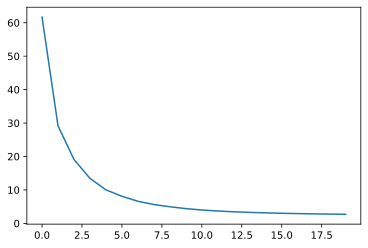

In [18]:
plt.plot(nlls)

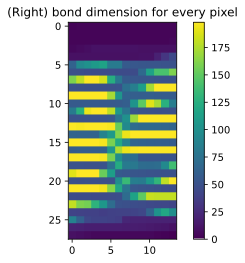

In [19]:
bdims_imshow(mps,(28,14))

(196,)


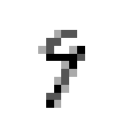

In [52]:
plot_img_gs(generate_sample(mps),(14,14) )

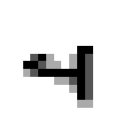

In [ ]:
corr_img = partial_removal_img(data[6], fraction = .6, axis = 0, shape=(28,14))


In [153]:
recc = reconstruct(mps, corr_img)


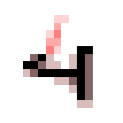

In [170]:
plot_rec(binary_to_img(corr_img,(14,14)), binary_to_img(recc,(14,14)), (14,14), N=4)

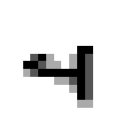

In [174]:
plot_img(binary_to_img(corr_img,(14,14)),(14,14))

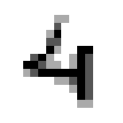

In [173]:
plot_img(binary_to_img(recc,(14,14)),(14,14))